1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import shuffle
#sns.set(rc = {'figure.figsize':(16,9)})
random_state = 12345
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines import CoxPHFitter

2. Import Datasets

In [2]:
# Read train data from IDA_2024
X_train = pd.read_csv("IDA_2024/train_operational_readouts.csv")
X_train_spec = pd.read_csv("IDA_2024/train_specifications.csv")
X_train_tte = pd.read_csv("IDA_2024/train_tte.csv")

3. Data exploring

The barplot for categorical data in SPEC

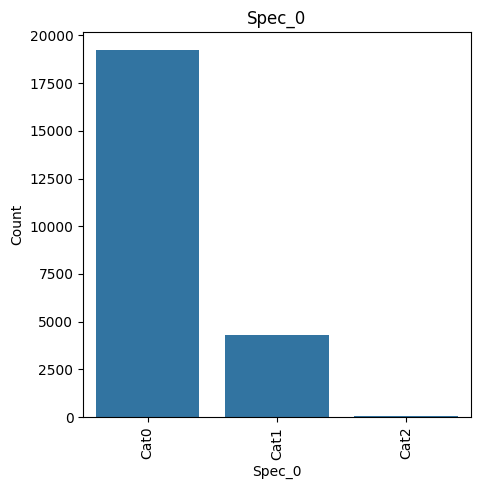

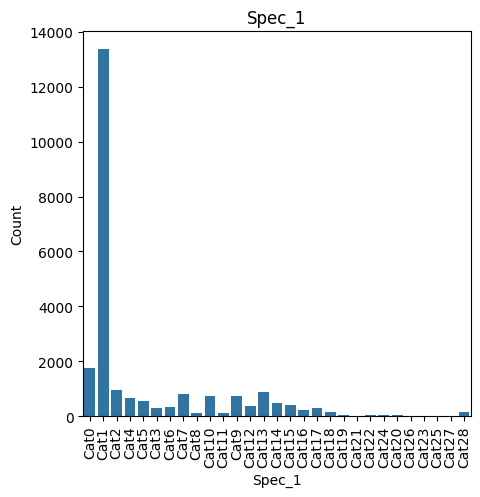

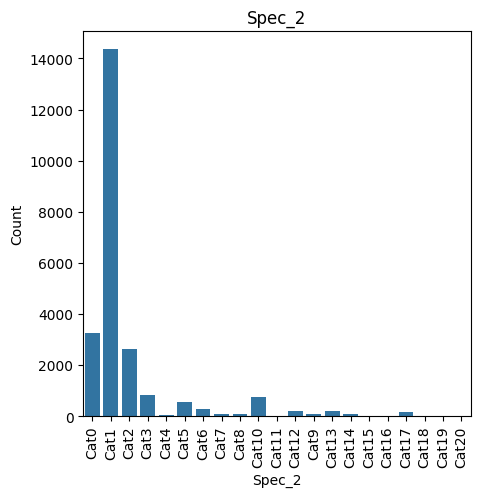

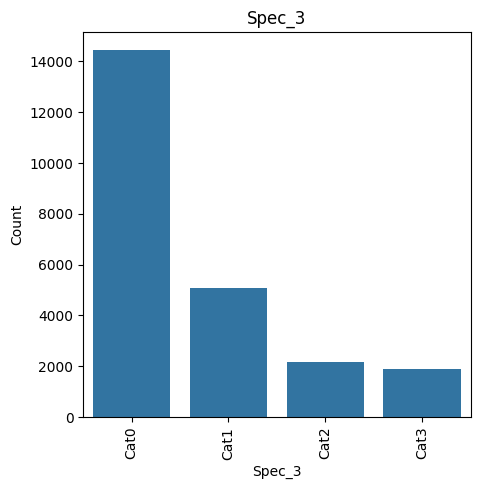

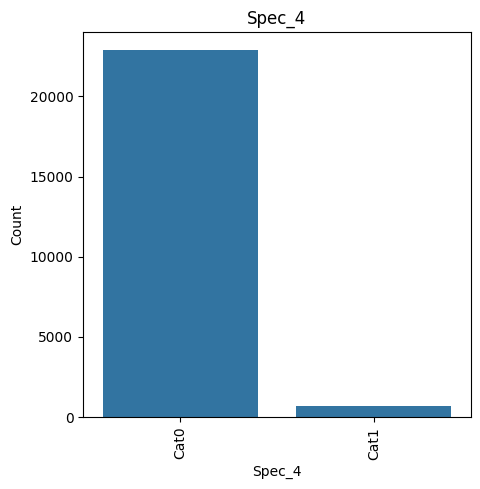

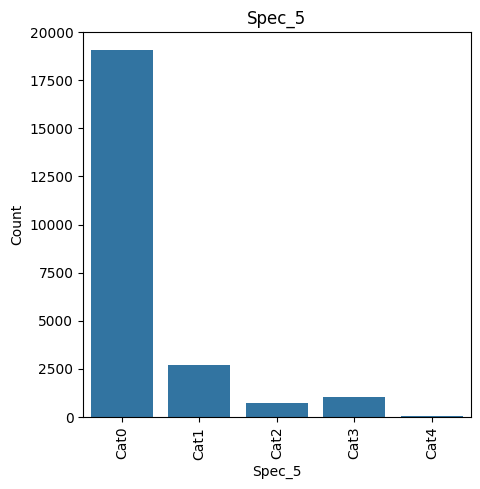

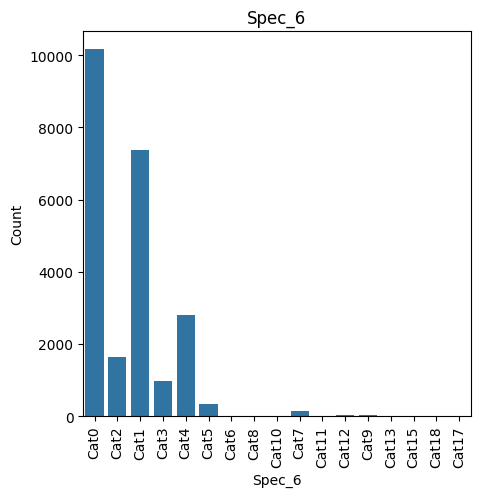

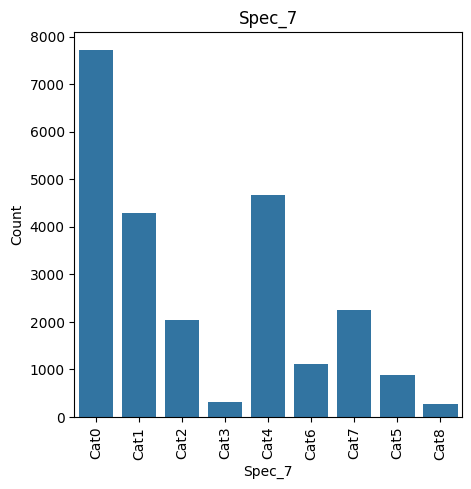

In [3]:
for i in X_train_spec.columns:
    if i != 'vehicle_id':
        target_column = i
# Plot the bar plot 
        plt.figure(figsize=(5,5))
        sns.countplot(data=X_train_spec, x=i)
        plt.title(i)
        
        plt.xticks(rotation=90)
        plt.ylabel('Count')  

        plt.show()

Distribution of lable

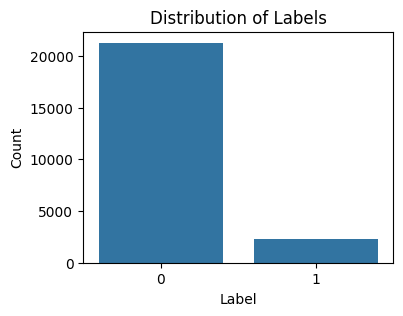

In [4]:
plt.figure(figsize=(4, 3))
sns.countplot(data=X_train_tte, x='in_study_repair')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Distribution of Missing value

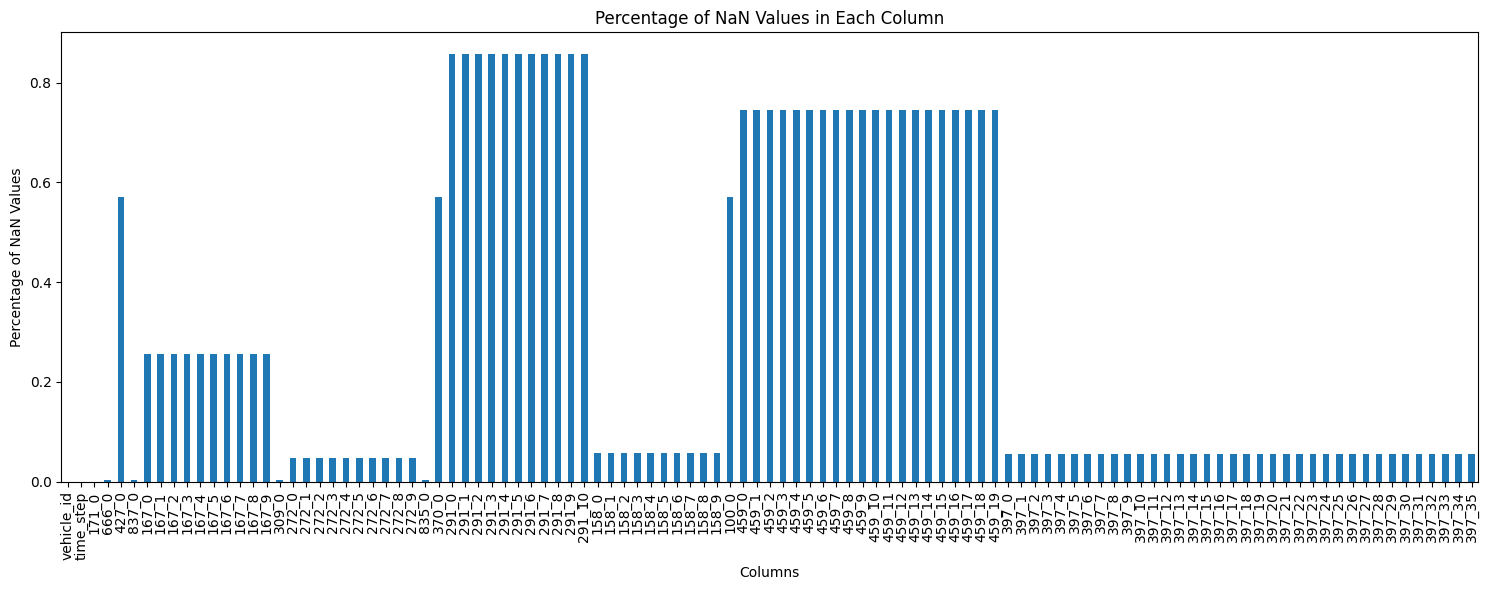

In [5]:
# Calculate the percentage of NaN values in each column
nan_percentage = (X_train.isnull().sum() / len(X_train)) * 100
# Plot the figure
plt.figure(figsize=(15, 6))
nan_percentage.plot(kind='bar')
plt.title('Percentage of NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN Values')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

Data Preprocessing

In [7]:
#Encoding Categorical data
spec_encoded = pd.get_dummies(X_train_spec)
spec_encoded = spec_encoded.replace({False: 0, True: 1}) 
categorical_col = spec_encoded.columns[1:]

#numerical features
numerical_col = X_train.columns[2:]

C:\Users\moka6903\AppData\Local\Temp\6\ipykernel_15184\1857747401.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spec_encoded = spec_encoded.replace({False: 0, True: 1})


Selecting last read out from operational dataset

In [8]:
# Select maximum cycle
max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)
X_train_max_cycle = X_train[X_train["time_step"] == max_cycle].reset_index()
X_train_max_cycle.drop(columns='index', axis = 1, inplace= True)

C:\Users\moka6903\AppData\Local\Temp\6\ipykernel_15184\1431256340.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  max_cycle = X_train.groupby(by="vehicle_id")['time_step'].transform(max)


Merging all three train datasets

In [9]:
# merged Scania train dataset and lable dataset and spec dataset
df_train = pd.merge(X_train_tte , X_train_max_cycle , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged=  pd.merge(df_train, spec_encoded , left_on='vehicle_id', right_on='vehicle_id')
dataset_merged.shape

(23550, 199)

Handeling missing Value by bfill

In [10]:
print('missing data in dataset:', dataset_merged.isna().sum().sum())
dataset_ffil = dataset_merged.bfill(axis = 0)
dataset_ffil.isna().sum().sum()

missing data in dataset: 11675


0

Creating RUL ans Status columns, necessary for lable sataset in survival analysis

In [11]:
# Create status column
dataset_ffil['status'] = dataset_ffil['in_study_repair'].apply(lambda x: False if x == 0 else True)
# Distribution of each status
print('X_train value_counts',dataset_ffil['status'].value_counts())
#creating RUL column
dataset_ffil['RUL'] = dataset_ffil['length_of_study_time_step'] - dataset_ffil['time_step']
print('Dataset Shape', dataset_ffil.shape)

X_train value_counts status
False    21278
True      2272
Name: count, dtype: int64
Dataset Shape (23550, 201)


Class distribution in time

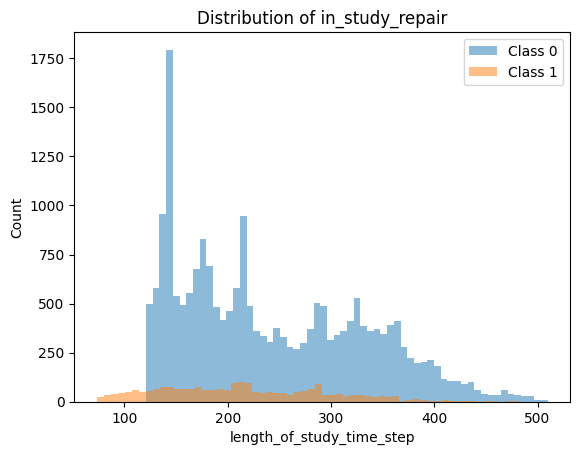

In [15]:
# Filter data for each class
class_0 = dataset_ffil[dataset_ffil['in_study_repair'] == 0]['length_of_study_time_step']
class_1 = dataset_ffil[dataset_ffil['in_study_repair'] == 1]['length_of_study_time_step']

# Plot histograms
plt.hist(class_0, bins=60, alpha=0.5, label='Class 0')
plt.hist(class_1, bins=60, alpha=0.5, label='Class 1')

# Add labels and legend
plt.title('Distribution of in_study_repair')
plt.xlabel('length_of_study_time_step')
plt.ylabel('Count')
plt.legend()

# Show plot
plt.show()

Correlation of Features with RUL

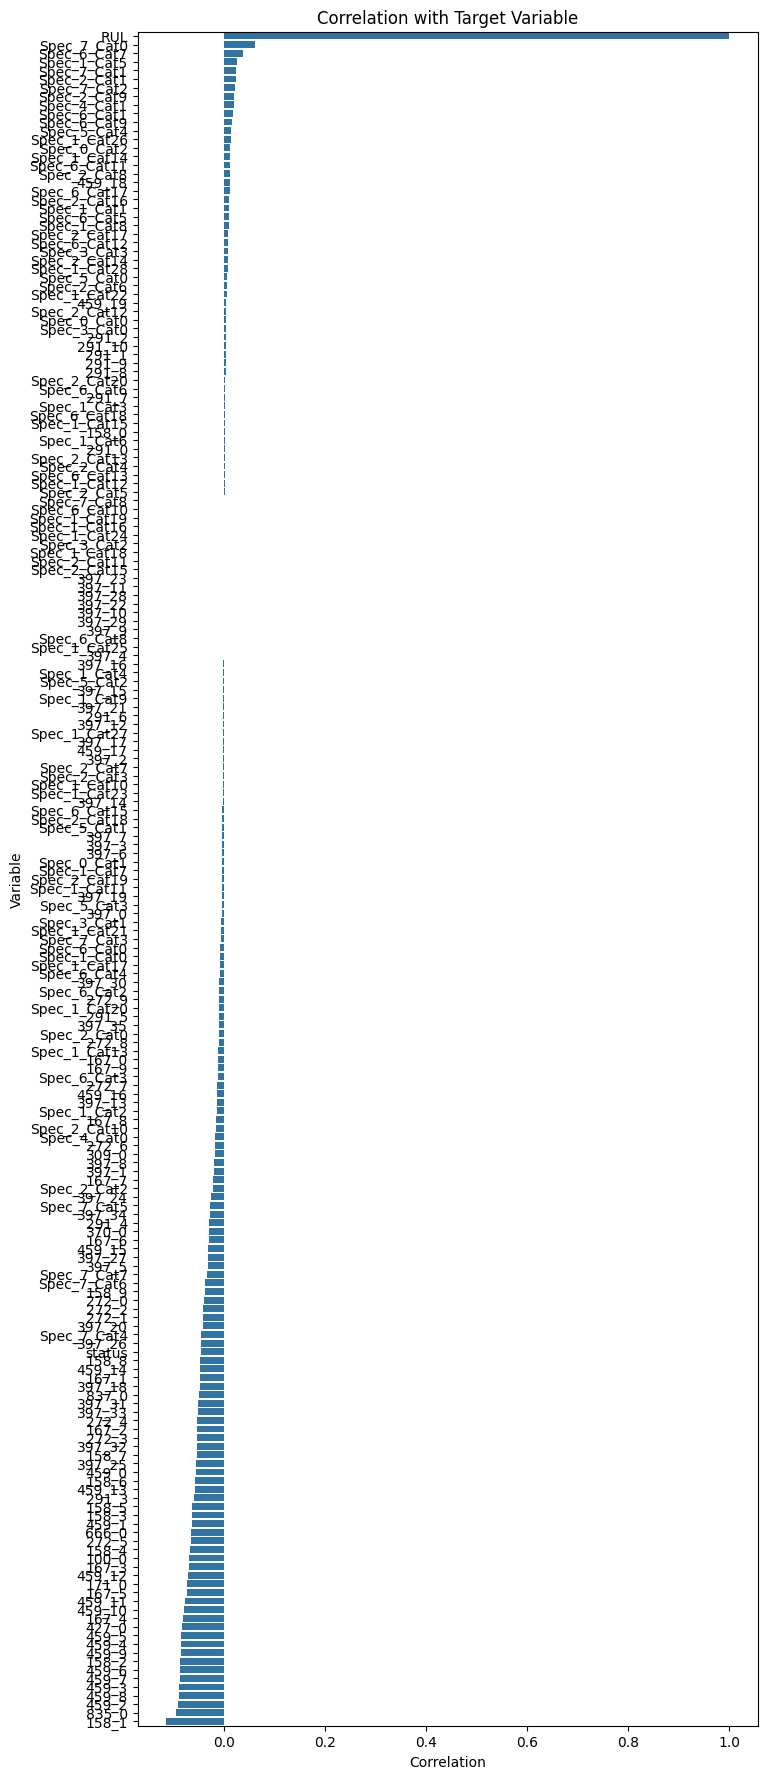

In [20]:
target_column = 'RUL'
Xtrain = dataset_ffil.drop(columns= ['in_study_repair', 'length_of_study_time_step', 'vehicle_id', 'time_step'])

# Compute the correlation matrix
correlation_matrix = Xtrain.corr()

# Extract the correlation of each variable with the target variable
correlation_with_target = correlation_matrix[target_column]

# Sort the correlations in descending order (optional)
correlation_with_target_sorted = correlation_with_target.sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(8, 22))
sns.barplot(x=correlation_with_target_sorted.values, y=correlation_with_target_sorted.index, orient='h')
plt.title('Correlation with Target Variable')
plt.xlabel('Correlation')
plt.ylabel('Variable')
plt.show()

features with Correlation with RUL< 0.01 are identified and removed

In [29]:
target_column = 'RUL'
df = dataset_ffil[list(numerical_col) + list(categorical_col) + ['RUL']].copy()
# Compute the correlation matrix
correlation_matrix = df.corrwith(df[target_column]).abs()

# Filter out correlations below the threshold
threshold = 0.01
filtered_correlations = correlation_matrix[correlation_matrix.abs() <= threshold]

# Sort the remaining correlations in ascending order
sorted_correlations = filtered_correlations.sort_values()
least_correlated_features = sorted_correlations.index.tolist()
# Print the least correlated features
print("Least correlated features:")
print(least_correlated_features, len(least_correlated_features))

dataset_droped_corr = dataset_ffil.drop(columns= least_correlated_features, inplace = False)
dataset_droped_corr.shape

Least correlated features:
['Spec_2_Cat5', 'Spec_7_Cat8', 'Spec_6_Cat10', 'Spec_1_Cat12', 'Spec_1_Cat19', 'Spec_1_Cat16', 'Spec_6_Cat13', 'Spec_2_Cat4', 'Spec_2_Cat13', '291_0', 'Spec_1_Cat24', 'Spec_1_Cat6', 'Spec_3_Cat2', '158_0', 'Spec_1_Cat15', 'Spec_1_Cat18', 'Spec_6_Cat18', 'Spec_2_Cat11', 'Spec_2_Cat15', 'Spec_1_Cat3', '397_23', '397_11', '397_28', '291_7', '397_22', '397_10', '397_29', 'Spec_6_Cat6', '397_9', 'Spec_6_Cat8', 'Spec_2_Cat20', 'Spec_1_Cat25', '397_4', '397_16', 'Spec_1_Cat4', 'Spec_5_Cat2', '291_8', '397_15', '291_9', 'Spec_1_Cat9', '397_21', '291_6', '397_12', 'Spec_1_Cat27', '291_1', '397_17', '459_17', '291_10', '291_2', 'Spec_3_Cat0', 'Spec_0_Cat0', '397_2', 'Spec_2_Cat7', 'Spec_2_Cat12', 'Spec_2_Cat3', 'Spec_1_Cat10', 'Spec_1_Cat23', '397_14', '459_19', 'Spec_6_Cat15', 'Spec_2_Cat18', 'Spec_5_Cat1', '397_7', 'Spec_1_Cat22', '397_3', '397_6', 'Spec_0_Cat1', 'Spec_1_Cat7', 'Spec_2_Cat19', 'Spec_2_Cat6', 'Spec_1_Cat11', '397_19', 'Spec_5_Cat0', 'Spec_5_Cat3', '39

(23550, 108)

Finding high correlation features

In [30]:

df2 = dataset_droped_corr.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id', 'status','RUL'], axis = 1)

# Define the correlation threshold
correlation_threshold = 0.90
correlation_matrix = df2.corr().abs()
# Get the upper triangle of the correlation matrix
upper_triangle = np.triu(correlation_matrix, k=1)

# Find the indices where the correlation exceeds the threshold
high_correlation_indices = np.where(upper_triangle > correlation_threshold)

# Initialize a list to store pairs of highly correlated variables
high_correlation_pairs = []
high_correlation_features = []
high_correlation_features_all = []

# Iterate through the indices and extract the variable pairs
for i, j in zip(high_correlation_indices[0], high_correlation_indices[1]):
    variable_i = correlation_matrix.index[i]
    variable_j = correlation_matrix.columns[j]
    correlation_value = correlation_matrix.iloc[i, j]
    high_correlation_pairs.append((variable_i, variable_j, correlation_value))
    high_correlation_features.append(variable_i)
    high_correlation_features_all.append(variable_i)
    high_correlation_features_all.append(variable_j)

# Print the highly correlated variable pairs
print("Highly Correlated Variable Pairs:")
for pair in high_correlation_pairs:
    print(pair)
print( list(set(high_correlation_features)))

Highly Correlated Variable Pairs:
('171_0', '427_0', 0.9730007497452052)
('171_0', '167_5', 0.9460448609594139)
('171_0', '158_4', 0.9262147919807299)
('427_0', '167_5', 0.9382254164771827)
('427_0', '835_0', 0.9303269247821015)
('427_0', '158_4', 0.9128112793731821)
('167_1', '272_0', 0.9400816811370624)
('167_5', '158_4', 0.9001366810567631)
('835_0', '158_2', 0.9104151987804896)
('291_4', '291_5', 0.932067975608117)
('158_4', '158_5', 0.9117096484768004)
('158_5', '158_6', 0.9705508849684782)
('158_5', '397_20', 0.9027896509711755)
('158_6', '158_7', 0.9097054380177748)
('158_6', '397_26', 0.906111555668511)
('158_8', '397_32', 0.9001561683485353)
('459_2', '459_3', 0.9621184433854746)
('459_2', '459_4', 0.9132452923656494)
('459_3', '459_4', 0.9757330762892937)
('459_3', '459_5', 0.936554709077647)
('459_4', '459_5', 0.9801950466014356)
('459_4', '459_6', 0.9295318585796065)
('459_5', '459_6', 0.9736551689124806)
('459_5', '459_7', 0.920422411187694)
('459_6', '459_7', 0.9708841383

Heatmap of feature correlations

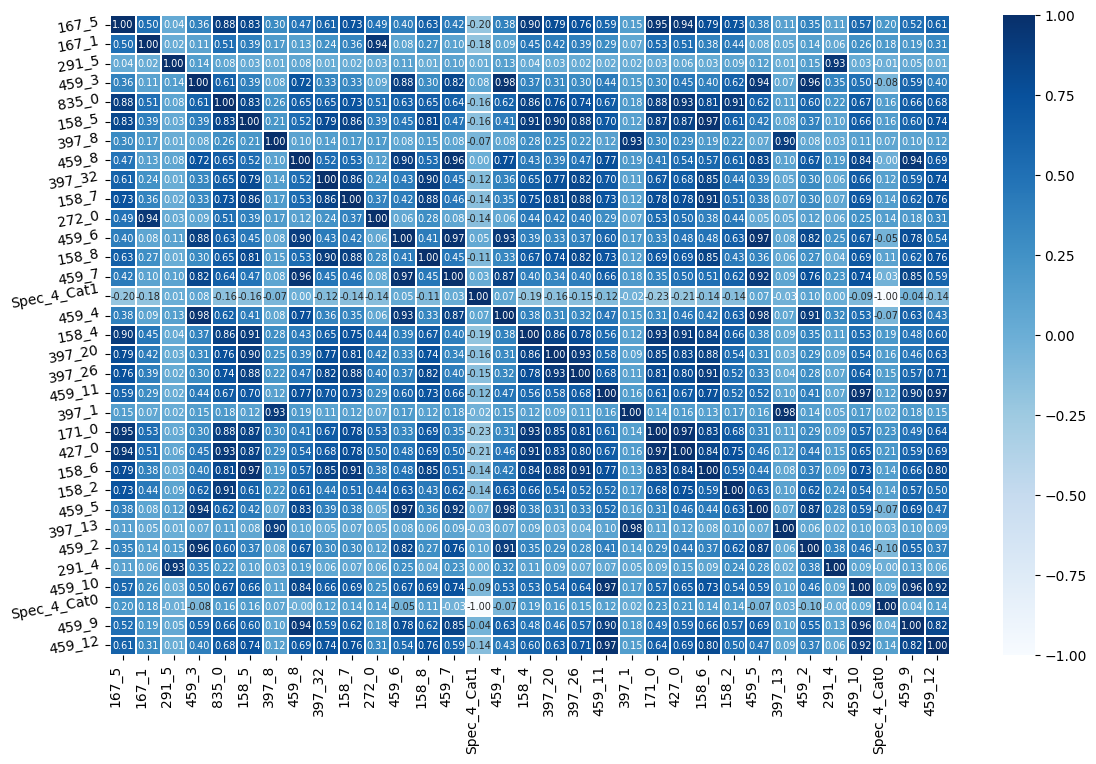

In [31]:
columns_high_corr= list(set(high_correlation_features_all))


heatmap =sns.heatmap(df2[columns_high_corr].corr(),annot=True,cmap='Blues',linewidths=0.2, annot_kws={"size": 7}, fmt ='.2f', xticklabels=True, yticklabels=True)
plt.subplots_adjust(left=0.15, right=0.85, top=0.95, bottom=0.15)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(rotation=10, fontsize=10)
plt.show()

In [32]:
main_data1 = dataset_droped_corr.drop(columns= list(set(high_correlation_features)))
main_data =main_data1.drop(columns= ['length_of_study_time_step', 'time_step', 'in_study_repair', 'vehicle_id'], axis = 1)
main_data

,666_0,837_0,167_0,167_2,167_3,167_4,167_6,167_7,167_8,167_9,...,Spec_6_Cat9,Spec_7_Cat0,Spec_7_Cat1,Spec_7_Cat2,Spec_7_Cat4,Spec_7_Cat5,Spec_7_Cat6,Spec_7_Cat7,status,RUL
0,372685.0,41670.0,10415.0,74655621.0,45991626.0,65888583.0,5813857.0,3351.0,0.0,0.0,...,0,1,0,0,0,0,0,0,False,2.6
1,289371.0,68717.0,10415.0,74655621.0,45991626.0,65888583.0,5813857.0,3351.0,0.0,0.0,...,0,0,1,0,0,0,0,0,False,0.8
2,230831.0,100121.0,5918.0,17004223.0,10504195.0,30792854.0,27370868.0,3819383.0,293456.0,101162.0,...,0,0,1,0,0,0,0,0,False,2.2
3,210381.0,152385.0,7128.0,13348382.0,11538870.0,30085352.0,53625651.0,1225967.0,7593.0,0.0,...,0,0,1,0,0,0,0,0,False,7.0
4,280531.0,164673.0,2688.0,13604867.0,14694395.0,41110339.0,15011017.0,689121.0,43760.0,13999.0,...,0,0,1,0,0,0,0,0,False,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23545,75859.0,10040.0,6631.0,10519563.0,8797533.0,27117757.0,6053328.0,32612.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,24.8
23546,138179.0,35726.0,15397.0,11640261.0,7568543.0,19594203.0,48183109.0,1682930.0,52639.0,0.0,...,0,0,0,0,1,0,0,0,False,1.4
23547,118371.0,9122.0,6783.0,6551850.0,6232055.0,17999988.0,12452989.0,108785.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,7.0
23548,80078.0,11251.0,755.0,16152271.0,7956861.0,17692205.0,9509643.0,483602.0,2240.0,0.0,...,0,0,0,0,1,0,0,0,False,0.2
